# Start work

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,concatenate, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.layers import Dropout, Conv2DTranspose, BatchNormalization
from keras.models import Model
from tensorflow.keras.metrics import MeanIoU
import tensorflow.keras.backend as K
from keras.preprocessing.image import ImageDataGenerator

import pandas as pd
import zipfile
import random
from PIL import Image
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os

from focal_loss import BinaryFocalLoss
import math

from sklearn.ensemble import RandomForestClassifier
from skimage.transform import rotate
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
tf.config.list_physical_devices('GPU')

import math

# 1.Load Data

In [2]:
#load zip file
zf = zipfile.ZipFile('data.zip') 
df_wafers = pd.read_csv(zf.open('df_wafers.csv'))
test = pd.read_csv(zf.open('df_wafers_test.csv'))

# 2. Preliminary data analysis

### 2.1 Removing the 'low yield' wafers

In [3]:
# Step 1
df_die_counts = df_wafers.groupby('WaferName',sort =None).size().reset_index(name='TotalDies')

test_die_counts = test.groupby('WaferName',sort = None).size().reset_index(name='TotalDies')
# Step 2
df_bad_die_counts = df_wafers[df_wafers['IsGoodDie'] == False].groupby('WaferName', sort=None).size().reset_index(name='BadDies')
test_bad_die_counts = test[test['IsGoodDie'] == False].groupby('WaferName',sort=None).size().reset_index(name='BadDies')

# Step 3
df_wafer_percentages = df_die_counts.merge(df_bad_die_counts, on='WaferName')
df_wafer_percentages['PercentageBadDies'] = df_wafer_percentages['BadDies'] / df_wafer_percentages['TotalDies']
test_wafer_percentages = test_die_counts.merge(test_bad_die_counts, on='WaferName')
test_wafer_percentages['PercentageBadDies'] = test_wafer_percentages['BadDies'] / test_wafer_percentages['TotalDies']

# Step 4
df_filtered_wafers = df_wafer_percentages[df_wafer_percentages['PercentageBadDies'] <= 0.15]['WaferName'].unique()
df_wafers = df_wafers[df_wafers['WaferName'].isin(df_filtered_wafers)]

test_filtered_wafers = test_wafer_percentages[test_wafer_percentages['PercentageBadDies'] <= 0.15]['WaferName'].unique()
test = test[test['WaferName'].isin(test_filtered_wafers)]


### 2.2 Data clasiffication  analysis

The number of unique wafers in the dataset is 3033 

The data contains 0 absent values 



False    13418976
True        78405
Name: IsScratchDie, dtype: int64

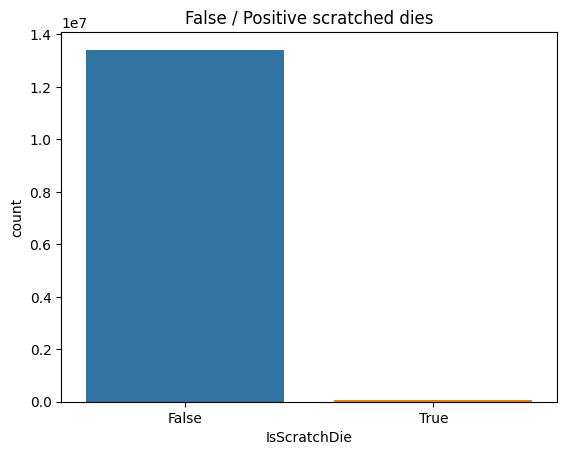

In [4]:
wafer_groups_by_name = df_wafers.groupby(by = "WaferName",sort=None)
unique_wafers = df_wafers["WaferName"].unique()
wafer_count = wafer_groups_by_name.size()
print(f'The number of unique wafers in the dataset is {len(unique_wafers)} \n')
print(f'The data contains {df_wafers.isnull().sum().sum()} absent values \n')
ax = sns.countplot(x = "IsScratchDie", data = df_wafers)
scratch_die_counts = df_wafers['IsScratchDie'].value_counts()
ax.set_title("False / Positive scratched dies")
scratch_die_counts

#### It's clear that there are far fewer scratch dies in the dataset than unscratch dies, indicating that the data is imbalanced.

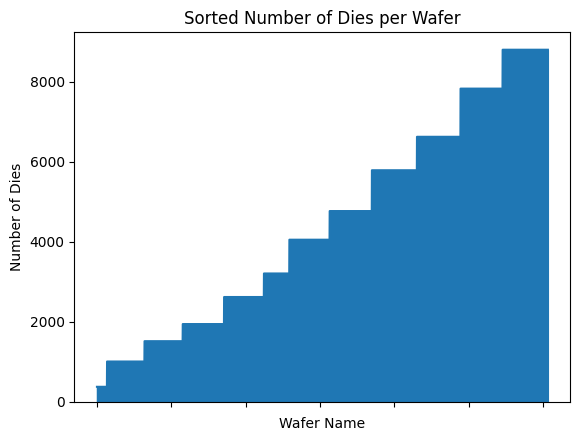

In [5]:
sorted_wafer_count = wafer_count.sort_values()
ax = sorted_wafer_count.plot(kind='area')
# Set the title and axis labels
ax.set_title('Sorted Number of Dies per Wafer')
ax.set_ylabel('Number of Dies')
ax.set_xlabel('Wafer Name')
ax.set_xticklabels([])
plt.show()


### As seen from the graph above, the number of dies varys from wafer to wafer, this is making the problem a bit trickier.

# 3.Preprocess Data

## 3.1 Data Augmentation

 As a part of my data augmentation strategy, I created a dictionary of scratch patterns based on the existing dataset. This allows me to generate new variations of the data by adding scratches to new wafers that will be added later on.

In [6]:
# Create an empty dictionary to hold the scratch banks
scratch_bank_dict = {}

# Group the data by WaferName
wafer_groups = df_wafers.groupby('WaferName',sort= None)

# Iterate over the wafer groups
for wafer_name, wafer_data in wafer_groups:
    # Check if any die in this wafer has a scratch
    if not wafer_data['IsScratchDie'].any():
        # If no scratches, skip this wafer
        continue    
    # Get the size of the wafer by taking the max DieX and DieY values
    die_x = wafer_data['DieX'].max()
    die_y = wafer_data['DieY'].max()
    tot_max = max(die_y,die_x)
    # Create an empty scratch bank as a numpy array
    scratch_bank = np.zeros((tot_max, tot_max))

    # Iterate over the rows in the wafer data and set the scratch locations in the scratch bank to 1
    for index, row in wafer_data.iterrows():
        if row['IsScratchDie']:
            x_idx = int(row['DieX']) - 1  # Subtract 1 to convert from 1-indexed to 0-indexed
            y_idx = int(row['DieY']) - 1
            scratch_bank[y_idx][x_idx] = 1

    # Add scratch bank to dictionary with wafer size as the key
    size_key = (tot_max, tot_max)
    if size_key in scratch_bank_dict:
        scratch_bank_dict[size_key].append(scratch_bank)

    else:
        scratch_bank_dict[size_key] = [scratch_bank]


### Ploting some arbitrary scratches from the scrach bank

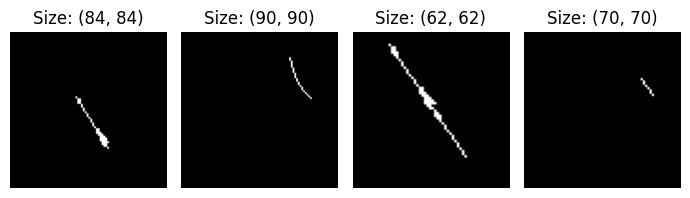

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(7,7))

for ax in axes.flatten():
    size = random.choice(list(scratch_bank_dict.keys()))
    scratch = random.choice(scratch_bank_dict[size])
    ax.imshow(scratch, cmap='gray')
    ax.set_title(f"Size: {size}")
    ax.axis('off')

plt.tight_layout()
plt.show()

After creating the scratch bank, I will add rotated versions of the scratches to each key in the dictionary to augment the dataset. This will improve the model's ability to recognize scratches from different angles and orientations

In [8]:
def add_rotated_scratches(scratch_bank_dict, num_scratches=3, angle_range=90, scale=1):
    # Iterate over the keys in the scratch bank dictionary
    for key in scratch_bank_dict.keys():
        # Get the scratch matrix array for this key
        scratch_matrix_array = scratch_bank_dict[key]
        # Get the dimensions of the scratch matrices in the array
        scratch_y, scratch_x = scratch_matrix_array[0].shape
        print(scratch_matrix_array[0].shape)
        # Add the specified number of scratches to the scratch bank array
        for i in range(num_scratches):
            # Choose a random scratch matrix from the array
            scratch_matrix = random.choice(scratch_matrix_array)
            # Choose a random angle to rotate the scratch matrix
            angle = random.randint(-angle_range, angle_range)
            # Define the rotation matrix and apply it to the scratch matrix
            center = (scratch_x // 2, scratch_y // 2)
            M = cv2.getRotationMatrix2D(center, angle, scale)
            rotated_scratch_matrix = cv2.warpAffine(scratch_matrix, M, (scratch_x, scratch_y), flags=cv2.INTER_NEAREST)
            # Ensure that there are no holes in the rotated scratch matrix
            rotated_scratch_matrix[rotated_scratch_matrix > 0] = 1
            # Create an empty scratch bank of the same size as the scratch matrices in the array
            scratch_bank = np.zeros((scratch_y, scratch_x))
            # Add the rotated scratch matrix to the scratch bank
            scratch_bank += rotated_scratch_matrix
            # Add the scratch bank to the scratch matrix array
            scratch_matrix_array.append(scratch_bank)

        # Update the scratch bank dictionary with the new scratch matrix array
        scratch_bank_dict[key] = scratch_matrix_array

    return scratch_bank_dict
add_rotated_scratches(scratch_bank_dict)

(34, 34)
(42, 42)
(48, 48)
(56, 56)
(62, 62)
(70, 70)
(76, 76)
(84, 84)
(90, 90)
(98, 98)
(104, 104)


{(34,
  34): [array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0.

## 3.2 Preprocess test data

In [19]:
test_max_x=0
test_max_y=0
test_images = []
test_groups_by_name = test.groupby(by = "WaferName",sort = None)
unique_test_wafers = test["WaferName"].unique()
for _, wafer_df in test_groups_by_name:    
    if test_max_x < wafer_df['DieX'].max():
        test_max_x = wafer_df['DieX'].max()
    if test_max_y < wafer_df['DieY'].max():
        test_max_y = wafer_df['DieY'].max()

test_max_x += 1
test_max_y += 1
closest_pow2 = 2 ** math.ceil(math.log2(max(test_max_x, test_max_y)))

test_max_x = closest_pow2
test_max_y = closest_pow2
image_size = (test_max_x, test_max_y)


for _, wafer_df in test_groups_by_name:

    # Create an empty image and label for each wafer
    image = np.zeros(image_size)

    # Set the corresponding pixel to white if the die is Bad
    good_mask = wafer_df['IsGoodDie'] == False 
    image[wafer_df.loc[good_mask, 'DieY'], wafer_df.loc[good_mask, 'DieX']] = 1

    # Add the image
    test_images.append(image)

# Convert the list to a numpy array
test_images = np.array(test_images)


### 3.2.0 To check the test set's validity, I'll plot a few images for visual inspection.

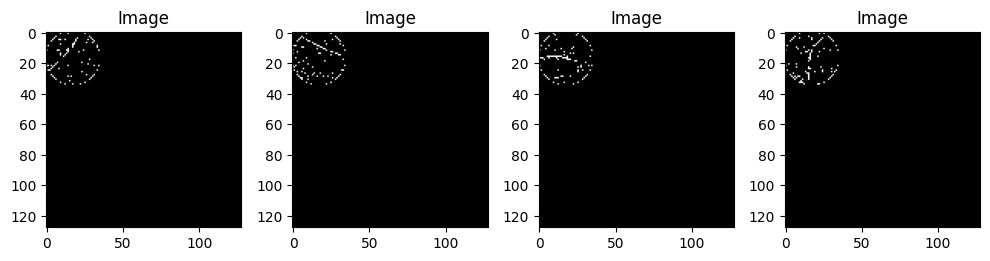

In [10]:
n_samples = 4
fig, axes = plt.subplots(1, n_samples, figsize=(10, 5))

for i in range(n_samples):
    axes[i].imshow(test_images[i], cmap='gray')
    axes[i].set_title('Image')

plt.tight_layout()
plt.show()

## 3.2.1 Preprocess training data

In [11]:
## Create a list to store the images and labels
images = []
labels = []
max_x = 0
max_y = 0

# Determine the size of the image based on the maximum values of DieX and DieY
for _, wafer_df in wafer_groups_by_name:
    if max_x < wafer_df['DieX'].max():
        max_x = wafer_df['DieX'].max()
    if max_y < wafer_df['DieY'].max():
        max_y = wafer_df['DieY'].max()
# add 1 to account for zero-indexing
max_x += 1
max_y += 1

#finding the closest power of 2 which is greater then max_x and max_y for the unet later on
closest_pow2 = 2 ** math.ceil(math.log2(max(max_x, max_y)))

max_x = closest_pow2
max_y = closest_pow2
image_size = (max_y, max_x)

# Iterate over each wafer
for _, wafer_df in wafer_groups_by_name:
    
    # Create an empty image and label for each wafer
    image = np.zeros(image_size)
    label = np.zeros(image_size)

    # Set the corresponding pixel to white if the die belongs to a scratch
    scratch_mask = wafer_df['IsScratchDie'] == True
    label[wafer_df.loc[scratch_mask, 'DieY'], wafer_df.loc[scratch_mask, 'DieX']] = 1

    # Set the corresponding pixel to white if the die is good
    good_mask = wafer_df['IsGoodDie'] == False 
    image[wafer_df.loc[good_mask, 'DieY'], wafer_df.loc[good_mask, 'DieX']] = 1
    
    # Add the image and label to the lists
    images.append(image)
    labels.append(label)

# Convert the lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

### 3.2.2 Adding the augmented data to the dataset

In [24]:
added_images = []
added_labels = []
df_scratches = df_wafers[df_wafers['IsScratchDie'] == True]
for wafer_name, wafer_data in wafer_groups:
    # Check if any die in this wafer has a scratch
    if not wafer_data['IsScratchDie'].any():
        # If no scratches, skip this wafer
        continue    
    # Get the size of the wafer by taking the max DieX and DieY values
    die_x = wafer_data['DieX'].max()
    die_y = wafer_data['DieY'].max()
    print(die_x)
    total_max = max(die_y,die_x)
    # create a square numpy array with dimensions max_x+1 x max_y+1, filled with zeros
    wafer_matrix = np.zeros((total_max, total_max))

    # add noise to the inscribed circle
    radius = min(wafer_matrix.shape) / 2
    center = np.array(wafer_matrix.shape) / 2
    num_noise_points = int(np.ceil(np.pi * radius**2 * np.random.uniform(0.07, 0.15)))
    idxs = np.random.choice(np.arange(wafer_matrix.size), num_noise_points, replace=False)
    coords = np.column_stack(np.unravel_index(idxs, wafer_matrix.shape))
    distances = np.linalg.norm(coords - center, axis=1)
    coords = coords[distances < radius]
    wafer_matrix[tuple(coords.T)] = 1

    # randomly choose a scratch with the same dimensions as the wafer
    scratch_bank = scratch_bank_dict.get((total_max,total_max))
    
    if scratch_bank is not None:
        num_of_scratches_to_add = random.randint(1,2)
        assemble_scratches = np.zeros((total_max, total_max))
        for i in range(num_of_scratches_to_add):
            scratch = random.choice(scratch_bank)
            # add the scratch to the wafer matrix
            wafer_matrix += scratch
            assemble_scratches+=scratch
            wafer_matrix = np.clip(wafer_matrix, 0, 1)
        # add the new wafer and corresponding label to the lists
        added_images.append(wafer_matrix)
        added_labels.append(assemble_scratches)

34
[1146  444  661  655  575  892  800  560  218    4  486 1078 1108 1036
  467  779  860  574  635  306  176 1010  234  967  250  588  303  388
  722 1130  158    7  213  641  741  677  754  463  457  546  426  872
  219  943  199  399  123  830  639   79  503  569 1020  563  597  308
  947  456  202  815   98  334  968  938  818  758  875  533  871   21
  608  454  526 1046  520  482  472  710  662  264  917  969 1135 1155
  196   29 1035]
34
[ 622  571  248  156  581  434  432  850  863  385  197  794 1141 1051
  704  700  821  843   81  856  721 1112  166  637  615  820  368  253
   17  444  616  116  521  619  937 1076   43 1012  612  357   75  902
  865  633  916  659  816  202  867  377  537  179  458  364  413  985
  947   76 1101 1003  915  852  759 1029  841  809  944  109  502]
34
[ 719  438 1049  815  441 1068  900  585  340 1005  811 1114  922  364
  874 1039   32   48  116  975  306  416   83 1092  288  250 1046    7
 1150  144  810  818    6 1104  745  666 1095  446   67

42
[ 290 1268 1333 1693  672  425 1404  464  263  881 1518  739  746 1032
 1584 1232 1512 1709 1421 1112 1433  192  388  414 1635 1279  552 1509
  651 1133 1140 1085  160 1297 1656 1445 1603  916 1360  628   14  137
  128  203 1459  265  725  946 1761  312  703 1127 1202  640 1632  224
 1175 1173  453 1482 1096 1375 1253 1100 1758  379  784   84 1145 1170
 1078 1651 1544 1702  557  622  393 1407 1332 1420 1495 1723  766  255
 1449  711  247  616 1610  569  687 1571  731 1020  648  950 1344 1653
 1224  531 1102  615 1094 1005  755  779  470 1604 1695  810  310 1463
  172 1001 1419  873  373  157  334 1743 1675   78  818 1568  577  732
 1617  462 1156 1699   46  556  357  189  844  266  689 1438 1618  304
 1621 1326  792  442 1165 1312 1531  699 1588  939  207  641   23  559
 1379 1754 1405  201  480  358 1260 1563 1606 1088  822  526 1592  458
  339  620  522 1183 1578  762  756  397 1416 1139  465 1573]
42
[1374 1675  425 1201 1245  136  978  200 1570  584  585  948  113   72
  641 175

48
[ 487 2008  864  753 1636  494 1537 1281 1563  557 2012  506 1679  355
 2061 1913  995 1424 1014  236 1358 1572 1860  621  687  234 2253  739
 1452 1982  338 2137 1645 2048 1676 1417  232 1955 1076 1697 1996  346
  994 2182  153  248  233  147  509   89 2148 1851  527 1011  192  175
 1296  490   12 1084  734 1600 1585  274 2075 1210 2222   44   32 1125
  460 1544  758 1728 1602 2102  786  273 1223 1743  284 1502  590  768
  272   73  573 1050 1599  197 2082  587 1101 1812  928   66  179 1954
 2286 1624 2117  792  774 1457  361 2044 1914 1340 1246  924 1439 1990
 1844  306   37  917 1540  417 1158 1177  462 1447 2092 1907  223 2250
  819 1431  968 2167 2276 2260 2116  419  735 1067  341 1938 1820 2069
 2014  612 1759 2201 1280  858 1786 2215 1413  547 2091 1008 1505 1017
 1061 1606 2113 2274 1359  425  642  681 1714 2292  759   38  442  875
 1773  722 1798 1924 1124  156  431 1244 1591 1029   40  688 1390 1315
  992  892   99  927  114 1275 2155  805 1966  459 2050 1492 2268 1532
 13

56
[2339  144 2188  749 2244 2845 3091 3053 2439  434  909  536 3030 1834
  949 1587 1377 1844 2336 1178 2438 2654 1573 1322 1173 2493 3024  493
 2497  742 1169    4 2328 2420 1201 2251  627 1747 1798 2795  486 2369
 1394 2117 1496 2510 1946 2694 2974 2773  133 2177  668 1127 2584 2903
  208 1385  558 2727  691 1044  468 1326  910 2319 3015 2678  487   23
 2335 2300 1962 2000 1461 1928 1606 1521 2967 1876   29  210 1705 1536
 1416  694 2567 3060 3093 2175 1180 3090 3014  412 2301  110 1209 2098
  529  371  225  442 2912 1172 2104 2945  811 1268 2579  333 2054 2361
 1832  515 2279 2500 2638 1600 2466 2399 1826 1408 2612 2494  604  432
 2343 2283 2002  180 1233 1684 1697 1370 3035 2048 2926   64 2443 1292
  608 2627 2028  685 2882 2645  987  859 1780 2631 1230  365 2925 2088
  728 2397 1114 2961 1002 1190  865  996 2558 2285 1272  707 2014   97
  721 1813 2209  631  168  359 2194 1746 1706 2471  842 1901 2093 3097
  170 1829  453 2514  384 1293 2341  872 1926  871  602 2395 1888   49
  9

62
[ 429 3631  976 2273 2356 3778 1287  534 1180 1800 2473 3489 1257 3114
 3095 2317 2630 2717   37   48 2749  578 3243 2646 1457 1031 3782  918
 1501 3366 2148 2752 1854 3539  636 2505 2393 2066 3360 1984 2160 1810
 1490  629 2737 2208 2757 1215  884 1110 2549 2490 1081 3282 2793 2298
 3723  253 1640  290 2795 2664 3494 2152   50 2290  515 2205 2989 1343
 2391  142 1848 1286  167 2627 2738 1217  643 3818 1150 3622  929 1658
 2185  676 2675 3090 1485 3193 2969 1397  384 1030  584 2942 3278 3229
 3138 2922 3048 2552 1722 1539 1115 3747 2783 1318 3337  368 1057 3610
  398 1418 2328 3655 1698  461 2833 1585 1301 2870  505   18 1831  240
  872  224 1908 3560 1557 2224 2871 1945 3148 1252  817 1056 1670 3823
  936  371 3759 1307 2037  781 3507  262 3419 2272 1521 2243 3017  948
   17 1798 2962  997 2698 1361  927 2150 3642  593 3725   57 1562 2400
 3150 2591 3343 3523 2745 2994 2130 1885 2407  562 1170 3537 3792 3623
 2695 3450  717  149  261 1025 3423 3648 1912 3779  735  453 3720 2095
  5

70
[4441 2967 3945 4759 4126 4878 4432  343   43  293 4545 4019 4157  252
 1246 1961 3114 3307 2635 3597 2441 4532  219 1085 3637 2198  286  344
 2698  347 2707 1333 4895 2880  702 2289 2890 1097 1437 3260 1478 3028
 3175 4358 4284   54 1418 3646 2264 1030  643  506 2015 4847  563  598
  458  974 1016 3736   45  120  417 4052 4780 4812 3802 4391 3663  447
 2598 3581 1348  410 1861 1335 3451 4242 3588 1362 1743 4482 1719 3702
 1103 4559 4388 2759 3962 4825 3850 4385 1668  341 4883 2369 3117  262
 4864 3212 3939 1546  707 3560 2727 1464 4758 3816 4757 4463 3190 1434
 2846 1121 1609 2969 3160   50 2106 2440 4598 3613 1951 2048 2723  814
 4583 4395  557 3163 3866 3833 4469 1364 2809 2661 2223 2663 3294 3614
 1533 2597 2828 3919 3277 3891 3926 1976  403 1371 1461 2174 3266 4357
 2173 3498 1204 3050 4117 3138 2260 1811 4362 3820 1819 3550 3024 1261
 1051 1972 2908 2506 4265  567 2594 4316 1585 4143 4161  523   92 2040
  161  533  584 1208 1688  750 2459  992 2177 4070 1725 1017 4861 2221
 22

76
[1757 3094 2962 1498 4401 4414  154 2624 4029  661 3525 2583 3333 3137
 1417 5498 1812 1481 3881 1058 2566 1848  254 3917 5148 2114 3159 4385
 5623  459  908 5210 1265 4997  383 3556 3157 3792 3118  740 3268 3316
  838 2428   39  412  403 1337 4382 4685 5265 5587 4470 1188 4852 5489
 5207 2511 1411 2297 1222  118 2762 3563 5232 5456 4349 4402 5306 5425
 3141  174 5470 5339 2842 2752 1730 3804 4946  485 3701  757 2078 4311
 4519 2016 5746  804 3446   20 5011 4214  432  333 4716 2353 2360 5748
 4360 2062 3617 5687 1259  911 4276 2769 3396 2600 3873 4581  681 4989
 3232 5188 1669 2450 4210   22  446 5398  877 3951 5731 1157 1308 3280
 2848 1676  883 2492  312 2125 1292 3759 3460  788 2056  265  543  644
 1382 3156 4488 5328 3677  302 3610 1196  364 1888 3703 2246 5115 1799
 3208 4550 3601 5178 2054 5058 2579 4992  157 3271 2102 5275 2627 5236
 4291 4782 5461 5335 4639 2156 2231 2490 4120 3187 1853 3631 1402 5346
 5139 4523  711  289  436 4070 5064  142 3908 4403 3909  502 1441 3638
 27

76
[3419 2198 3135 2143 5399 1535 5481 2064  155  645 2351 5659  936 3758
 5682 5076 4356   43 3626 1692 4333 5454 4247 2631 1761 3090 2183 4455
 2773 4914 4078 4170 1135 1492 3036 5716 4163 5395 2574 4475 5152 3632
 2343 2905 3155 3792  183  482  598 4532 4691 1002 2591 5677 4907 3851
 1390 1094  488  287  947 4031 1924 3129 3065 5595 1248 2581 4467  614
 3505 3965 3255 1607  140 1057 1621 2515 4999 4312 5313 3508 5280  695
  621 5520  690  323 1200  693  119  284 5182 3888  938  518 5739 1673
 2080 3499 4373 5699 2383 3293 2514 3896 1759 4415 3277 5204  825 3871
 2929 1974 3818  762 5372 3939 3782 2176 2827 2434 4285 5609 4576   41
 4127 5016 2274 4881  365 2512 4099 4984  138 3154 2416 1808 4254 4457
 4065 1141 3294 3644 1498 5447 4613 4042 3707  360 4220  154  373 1027
 1919 2120 2102 5620 5386 4207 4171 2053 3366 1882 1971  767 3392 4007
 5448 2242 5411 5238 2395 2564  302  144 2124 2541 5384 5414 2377  978
 4324 4882 1199 4968 2720 3855 4050 4728 1537 5585 1757  508 3805 1472
 30

84
[4509 1729  790 2950 2513 3491  538 1382 4194 5250 3308 1207 2596 1941
 4664 6596 1160  204 3611 4710  714  725 4639 4371 5138 3514 4256 4186
 4684 3447 1826 3191 4789 3971 3901 5560  983 1930   37 6190  716 1579
 4520 5203 4346 1661 4708 2491 4109 3892 6639 1213 6583 6814  942 6237
 6830 5109 5871 3586  499 5815 3337  608 5640 3883 3990  325 5804 7020
 2725 3432  273 2056 3369 4705 2908 5273 3942  990 2208 2886 4242 2499
 3517 4465 6870 1910 5480 6637 4604 3149 2719 2160  120 1604 2975  421
  853 2138 3914 1667 4820  863 5510 3851 2633 5822 3637 3425 2698 3685
 1920 4502  648 2042 5887 7010 1202 4087 3218 1647 3054 3876 5131  733
  159 4470 1801  486 6907 1969 3552  336 2224 6053 2313 3048 5106 5716
 2455 4873 5439 2219 3634 1150 4474 6818 3607 3058 5080 6224 5233 3124
 2116 6922 4673 2118 7041 5390 3072  121 3502 3596 3226 5515 2297 1539
 5831 5634 5288 6810  176 7032 6740 4177 7009 6280 6276 5287 2180 2807
 5695 4190 1432 4458 5268 6987 4134 1187 5843 2819 1527 6359 5214  879
 14

90
[1470 7379 6307 5262 1623 2914 4326 4440 6038 5794 2891  275 2409 1642
 6875 8094 1603 5971 7384 3262 6827 3995 7751 3843 6395 1598  353 2851
 4534 4610 7731 2161 4434 1496 7308 3024 4202 2412 3918 6275 2902 2736
  801 2070 2181 6933 4160 2122 4951 2157 4852 6697 5614 4314  308 5595
  361 3274 6126 3500  984 2350 7110 1862 2382 3134 5816 1233 1540 3601
 2262 3508 6779 6506 7550 3085 3143 2804 7184 4783 7216 1531 8050 7020
 3710 2490 3256   69 6409 3159 5285 7508 5933 7439 7115 7610 7210 8036
 7724 1475 1088  859 5542 1992 1131 7012 4387 5725 3982 2632 3438 5401
 7938 7933 5866  436 3285 3634 1380 2090 5676 4570  891 8065 4791 6229
 5939 1500 1246 2144 3582 3887 4889 6997 7281 4304 1396 7134 6883  918
 3093 4059   40 1921 1313 4528 7418 1495 4206 3034  190 2364 2769 7753
 1571 1046 1619 7258 6132 4204 6705 2497 2288 7613 3862 5779 7575 1988
 7606 2751   68 7581 3516 7088 5425  398 5840 1117 7709 3946 5325 7950
 7920  820 6397  285 4477 3020 5012 2153 1510  507 5388  545 1078 1614
 34

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [13]:
for i in range(len(added_images)):
    added_images[i] = np.pad(added_images[i], ((0, closest_pow2 - added_images[i].shape[0]), 
                                                (0, closest_pow2 - added_images[i].shape[1])), 
                                                mode='constant')
    
    added_labels[i] = np.pad(added_labels[i], ((0, closest_pow2 - added_labels[i].shape[0]), 
                                                (0, closest_pow2 - added_labels[i].shape[1])), 
                                                mode='constant')

### 3.2.3 To check the augmented set's validity, I'll plot a few images for visual inspection.

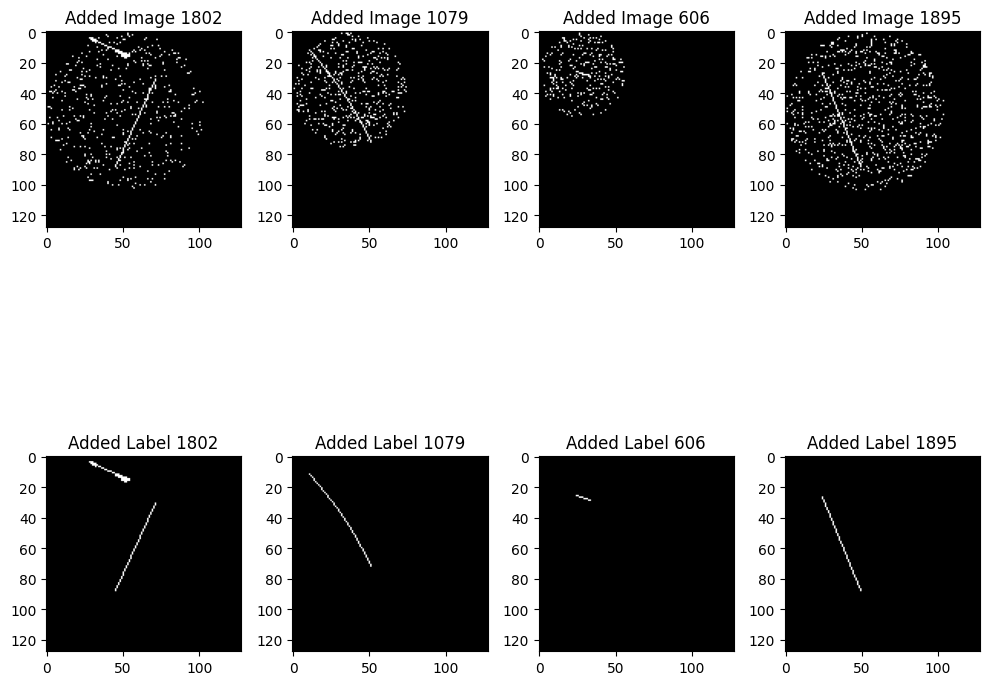

In [14]:
n_samples = 4  # number of samples to show
fig, axes = plt.subplots(2, n_samples, figsize=(10, 10))

for i in range(n_samples):
    # choose a random pair of added image and label
    idx = random.randint(0, len(added_images)-1)
    added_image = added_images[idx]
    added_label = added_labels[idx]

    # plot the added image with the image number
    axes[0, i].imshow(added_image, cmap='gray')
    axes[0, i].set_title(f'Added Image {idx}')

    # plot the added label with the image number
    axes[1, i].imshow(added_label, cmap='gray')
    axes[1, i].set_title(f'Added Label {idx}')

plt.tight_layout()
plt.show()

### 3.2.4 Same with the train data

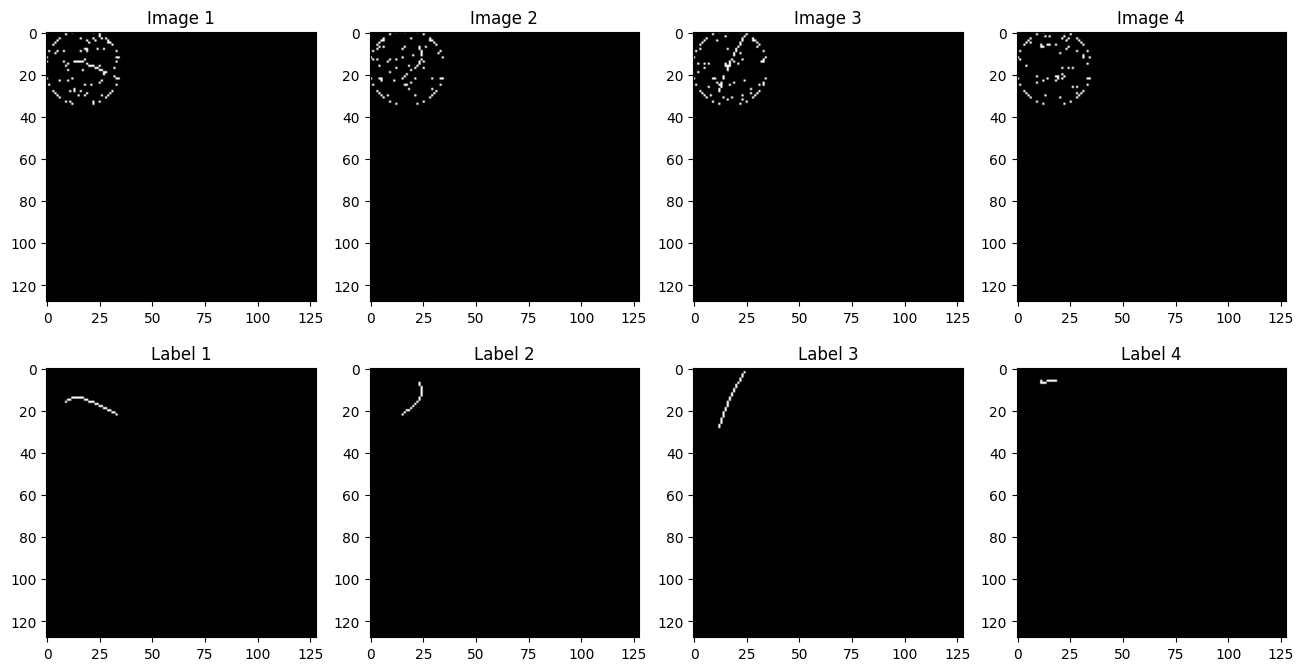

In [15]:
i = 4

# Create a figure with 4 subplots
fig, axs = plt.subplots(nrows=2, ncols=i, figsize=(16, 8))

# Plot each image and label in the chosen indices
for j, idx in enumerate(range(i)):
    axs[0][j].imshow(images[idx], cmap='gray')
    axs[0][j].set_title(f"Image {j+1}")
    axs[1][j].imshow(labels[idx], cmap='gray')
    axs[1][j].set_title(f"Label {j+1}")

# Show the figure
plt.show()

### 3.2.5 Concatenating the two datasets and preparing the data for model training

In [16]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [17]:
X_train = np.concatenate((X_train, added_images))
y_train = np.concatenate((y_train, added_labels))

## 4. Model

### 4.1 Impelemtind the dice coefficient metric

In [18]:
def dice_coef(y_true, y_pred, smooth=1):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [19]:
# Assuming the images are grayscale
num_channels = 1
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

    # Expansive path
    u4 = UpSampling2D(size=(2, 2), interpolation='bilinear')(c3)
    u4 = concatenate([u4, c2])
    c4 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    u5 = UpSampling2D(size=(2, 2), interpolation='bilinear')(c4)
    u5 = concatenate([u5, c1], axis=3)
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = Dropout(0.1)(c5)
    c5 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.summary()

    return model

model = simple_unet_model(max_x, max_y, num_channels)
model.compile(optimizer='adam', 
              loss = dice_loss,
              metrics=[dice_coef])
model.fit(X_train, y_train, epochs=30,  batch_size=8)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [20]:
# current_directory = os.getcwd()

# tf.keras.models.save_model(
#     model,
#     current_directory,
#     overwrite=True,
#     include_optimizer=True,
#     save_format='tf'
# )

## 4.2 Evaluating the model's performance on the validation set.

In [21]:
# Use the trained model to make predictions on the validation set
y_pred_val = model.predict(X_val)

# Threshold the predicted output to convert it to binary (0 or 1)
y_pred_val_binary = (y_pred_val > 0.5).astype(np.float32)
# Convert y_val to float32
y_val_float = y_val.astype(np.float32)

# Compute the dice coefficient on the validation set
val_dice_coef = dice_coef(y_val_float, y_pred_val_binary)

# Compute the accuracy on the validation set
val_accuracy = accuracy_score(y_val_float.flatten(), y_pred_val_binary.flatten())

# Print the results
print('Validation Dice Coefficient:', val_dice_coef)
print('Validation Accuracy:', val_accuracy)


19/19 [==============================] - 6s 267ms/step
Validation Dice Coefficient: tf.Tensor(0.83479476, shape=(), dtype=float32)
Validation Accuracy: 0.9994884912028933


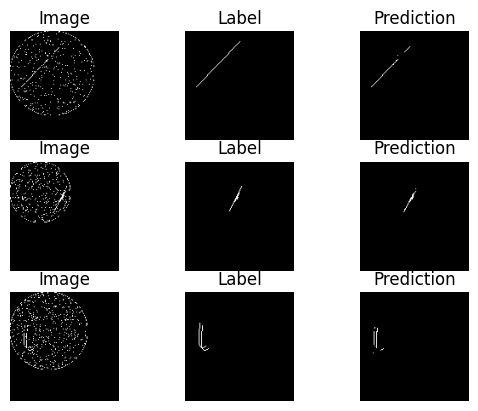

In [22]:
num_samples = 3
indices = np.random.randint(len(X_val), size=num_samples)

for i, index in enumerate(indices):
    # Plot the test image
    plt.subplot(num_samples, 3, 3*i+1)
    plt.imshow(X_val[index], cmap='gray')
    plt.title("Image")
    plt.axis('off')

    # Plot the ground truth label
    plt.subplot(num_samples, 3, 3*i+2)
    plt.imshow(y_val[index], cmap='gray')
    plt.title("Label")
    plt.axis('off')

    # Plot the predicted output
    plt.subplot(num_samples, 3, 3*i+3)
    plt.imshow(y_pred_val_binary[index], cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

plt.show()

Results over validation:
1) 0.815 - with the added data, 16 conv on the first layer and 8 on the others (6 layers architecture)  epochs=30,  batch_size=16

2) 0.812 - without the added data, 16 conv on the first layer and 8 on the others (6 layers architecture)  epochs=30,  batch_size=16

3) 0.839 - with the added data, 16 on the first two and last. epochs = 30, batch_size = 8.


## Build your solution

In [25]:
y_pred_val = model.predict(test_images)
y_pred_val_binary = (y_pred_val > 0.5).astype(np.float32)

11/11 [==============================] - 4s 327ms/step


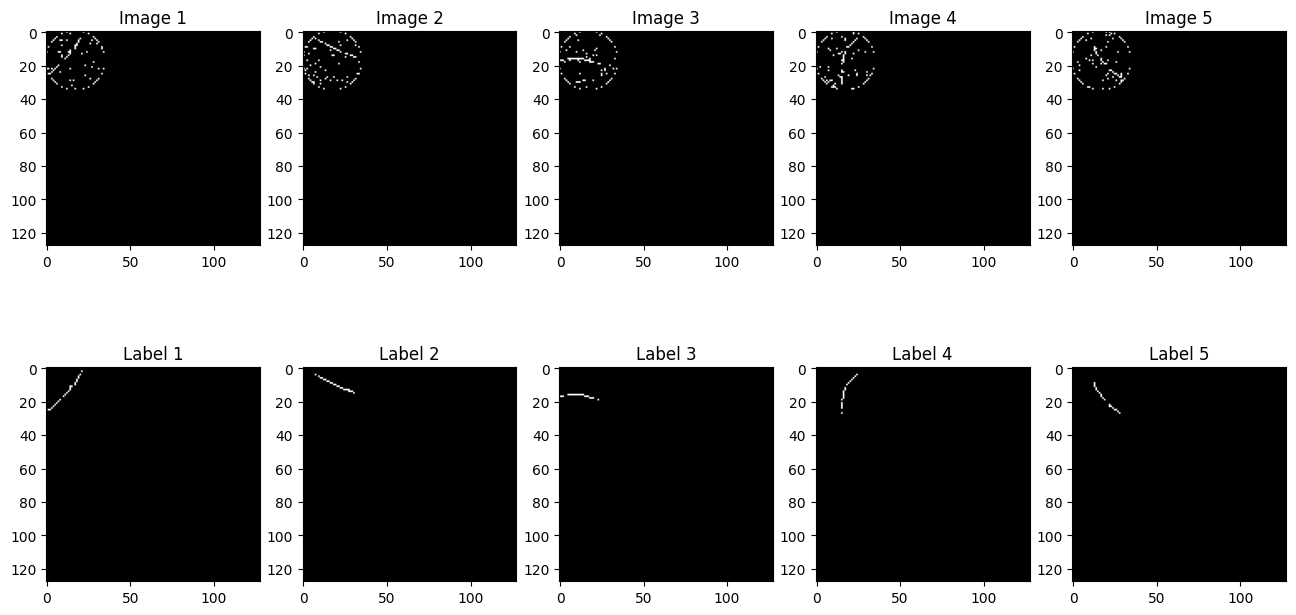

In [26]:
k=5
# Create a figure with 4 subplots
fig, axs = plt.subplots(nrows=2, ncols=k, figsize=(16, 8))

# Plot each image and label in the chosen indices
for i in range(0,k):
    axs[0][i].imshow(test_images[i], cmap='gray')
    axs[0][i].set_title(f"Image {i+1}")
    axs[1][i].imshow(y_pred_val_binary[i], cmap='gray')
    axs[1][i].set_title(f"Label {i+1}")

# Show the figure
plt.show()

## Adding the IsScratchDie to the csv file

In [27]:
test['IsScratchDie'] = 0
# Loop through each unique wafer name in the DataFrame
for i, wafer_name in enumerate(test['WaferName'].unique()):
    # Get the indices of the rows in the DataFrame that correspond to the current wafer
    wafer_rows = test.loc[test['WaferName'] == wafer_name]
    # Get the predicted scratch values for the current wafer
    wafer_pred = y_pred_val_binary[i]
    # Update the IsScratchDie values for the rows in the current wafer
    test.loc[wafer_rows.index, 'IsScratchDie'] = [int(wafer_pred[r['DieY'], r['DieX']]) for _, r in wafer_rows.iterrows()]


In [28]:
test.to_csv('df_wafers_test.csv', index = False)

# Plotting the test data - just to be sure

In [29]:
test_check_images = []
test_check_labels = []

image_size = (max_y, max_x)
test_wafer_groups_by_names = test.groupby(by = "WaferName", sort = None)
# Iterate over each wafer
for _, wafer_df in test_wafer_groups_by_names:
    # Create an empty image and label for each wafer
    test_image = np.zeros(image_size)
    test_label = np.zeros(image_size)
    
    # Set the label of bad dies to 1
    scratch_mask = wafer_df['IsScratchDie'] == 1
    test_label[wafer_df.loc[scratch_mask, 'DieY'], wafer_df.loc[scratch_mask, 'DieX']] = 1
    
    # Set the label of good dies to 0
    good_mask = wafer_df['IsGoodDie'] == 0
    test_image[wafer_df.loc[good_mask, 'DieY'], wafer_df.loc[good_mask, 'DieX']] = 1
    

    # Add the image and label to the lists
    test_check_images.append(test_image)
    test_check_labels.append(test_label)
    
test_check_images = np.array(test_check_images)
test_check_labels = np.array(test_check_labels)


    

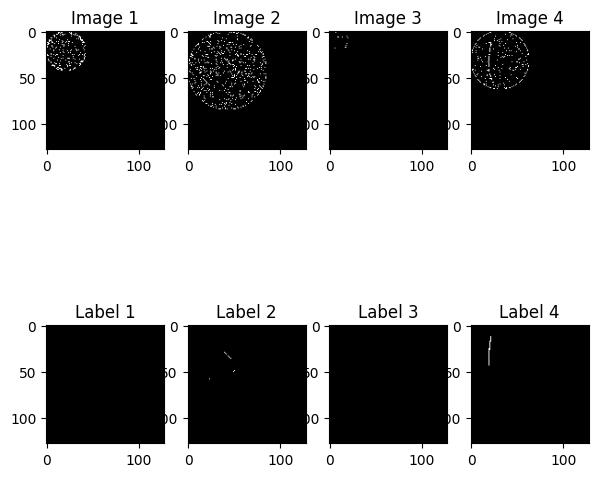

In [37]:
# Set the number of random images to display
num_images = 4

# Select num_images random indices from the dataset
random_indices = random.sample(range(len(test_check_images)), num_images)

# Create a figure with num_images subplots
fig, axs = plt.subplots(nrows=2, ncols=num_images, figsize=(7,7))

# Loop through the randomly selected images and labels
for j, idx in enumerate(random_indices):
    # Plot the jth random image and label
    axs[0][j].imshow(test_check_images[idx], cmap='gray')
    axs[0][j].set_title(f"Image {j+1}")
    axs[1][j].imshow(test_check_labels[idx], cmap='gray')
    axs[1][j].set_title(f"Label {j+1}")

# Adjust the spacing between the subplots

# Show the figure
plt.show()

Looking good :)

## Additional thoughts

- Upon receiving the assignment, my initial idea was to investigate the possibility of solving the problem using computer vision rather than machine learning. My motivation behind this was to explore whether computer vision could offer a more efficient solution, as it often requires less computational time. After conducting further research on the Hough transform, I came to the realization that it would not be feasible to use this technique for the given problem. This is because the scratches in the image exhibit significant variability in both their size and shape, which makes it difficult to identify a consistent set of parameters that would accurately detect all the scratches in the image.


- During the process of exploring the data, I noted a significant variation in the size of the wafers. This presented a challenge for my solution, as it required additional time and may have negatively impacted the performance of the model. However, I considered the possibility of developing a separate model for each wafer size, which would require more data and training time, but could potentially improve the accuracy of the predictions substantially.